In [ ]:
from pynq.overlays.base import BaseOverlay
import asyncio
import time

# Load overlay
base = BaseOverlay("base.bit")
btns = base.btns_gpio


In [2]:
%%microblaze base.PMODB

#include "gpio.h"
#include "pyprintf.h"

void write_gpio(unsigned int pin, unsigned int val){
    gpio g = gpio_open(pin);
    gpio_set_direction(g, GPIO_OUT);
    gpio_write(g, val);
}

#// Reset all PMODB pins
void clear_pin(unsigned int pin){
    write_gpio(pin, 0);
}


In [69]:
def setPWMpin(pin, dutyCyle, frequency):
    pwm_frequency = frequency        # Vary until no flicker Hz
    duty_cycle = dutyCyle       # percent (0–100)
    run_time = 20.0              # seconds to run PWM

    period = 1.0 / pwm_frequency        # total period (seconds)
    on_time = period * (duty_cycle / 100.0)
    off_time = period - on_time

    # if duty cylce is less than or equal to zero
    # hold pin off
    if duty_cycle <= 0:
        write_gpio(pin, 0)
        time.sleep(run_time)
        
    # if duty cylce is less than or equal to 100
    # hold pin on
    elif duty_cycle >= 100:
        write_gpio(pin, 1)
        time.sleep(run_time)

    else:
        start_time = time.time()

        while (time.time() - start_time) < run_time:
            write_gpio(pin, 1)          # ON
            time.sleep(on_time)
            #time.sleep(1)
            write_gpio(pin, 0)         # OFF
            time.sleep(off_time)
            #time.sleep(1)

In [70]:
# Set the PWM on pin 3: RED
# Clear all pins
PIN_RED   = 3
PIN_GREEN = 2
PIN_BLUE  = 1

clear_pin(PIN_BLUE)
clear_pin(PIN_BLUE)
clear_pin(PIN_RED)
frequency = 10  # 10 times a second
setPWMpin(3, 0.25, frequency)

In [71]:
# Set the PWM on pin 2: GREEN
# Clear all pins
clear_pin(PIN_BLUE)
clear_pin(PIN_BLUE)
clear_pin(PIN_RED)
frequency = 100  # 100 times a second
setPWMpin(2, 0.75, frequency)

In [72]:
# Set the PWM on pin 1: BLUE
# Clear all pins
clear_pin(PIN_BLUE)
clear_pin(PIN_BLUE)
clear_pin(PIN_RED)
frequency = 1000  # 1000 times a second
setPWMpin(1, 1, frequency)

In [3]:
# CONFIGURATION
DUTY = 0.25          # 25%
BLINK_PERIOD = 2.0   # 1 sec ON + 1 sec  OFF

# PMODB RGB pin mapping
PIN_RED   = 3
PIN_GREEN = 2
PIN_BLUE  = 1


# SHARED STATE
state = {
    "color": "red",
    "blinking": True
}


# LED CONTROL

def all_off():
    clear_pin(PIN_RED)
    clear_pin(PIN_GREEN)
    clear_pin(PIN_BLUE)

def set_color(color, value):
    all_off()
    if color == "red":
        write_gpio(PIN_RED, value)
    elif color == "green":
        write_gpio(PIN_GREEN, value)
    elif color == "blue":
        write_gpio(PIN_BLUE, value)


# BLINK TASK (1 Hz, 25% duty)

async def blink_task():
    on_time  = BLINK_PERIOD * DUTY
    off_time = BLINK_PERIOD * (1 - DUTY)

    while True:
        if state["blinking"]:
            set_color(state["color"], 1)
            await asyncio.sleep(on_time)

            all_off()
            await asyncio.sleep(off_time)
        else:
            all_off()
            await asyncio.sleep(0.1)


# BUTTON TASK

async def button_task():
    # Previous buttons
    prev = [0, 0, 0, 0]

    while True:
        # Read buttons pushed  and save in btn
        btn = [btns[i].read() for i in range(4)]

        if btn[0] and not prev[0]:
            state["color"] = "red"
            state["blinking"] = True
            print("BTN0 → RED")

        if btn[1] and not prev[1]:
            state["color"] = "green"
            state["blinking"] = True
            print("BTN1 → GREEN")

        if btn[2] and not prev[2]:
            state["color"] = "blue"
            state["blinking"] = True
            print("BTN2 → BLUE")

        if btn[3] and not prev[3]:
            state["blinking"] = False
            print("BTN3 → STOP")
            
        # Save previously pushed button
        prev = btn
        await asyncio.sleep(0.05)

In [ ]:
# Schedule all tasks in main()
async def main():
    asyncio.create_task(blink_task())
    asyncio.create_task(button_task())
    await asyncio.sleep(9999)

# Launch tasks
asyncio.run(main())

BTN1 → GREEN
BTN2 → BLUE
BTN3 → STOP
BTN0 → RED
BTN1 → GREEN
BTN2 → BLUE
BTN3 → STOP
BTN0 → RED
BTN0 → RED
BTN0 → RED
BTN3 → STOP
BTN0 → RED
BTN0 → RED
BTN1 → GREEN
BTN2 → BLUE
BTN3 → STOP
BTN0 → RED
BTN1 → GREEN


In [56]:
# Visual Perception cell

import numpy as np

# PWM duty cycle values (percent)
duty_cycles = np.array([0, 5, 10, 25, 50, 75, 100])

# Gamma value for human vision
gamma = 2.2

# Normalize duty cycle
duty_norm = duty_cycles / 100.0

# Compute perceived brightness
brightness = (duty_norm ** (1 / gamma)) * 100

# Show results
for d, b in zip(duty_cycles, brightness):
    print(f"Duty Cycle: {d:>3}%  →  Perceived Brightness: {b:6.1f}%")

Duty Cycle:   0%  →  Perceived Brightness:    0.0%
Duty Cycle:   5%  →  Perceived Brightness:   25.6%
Duty Cycle:  10%  →  Perceived Brightness:   35.1%
Duty Cycle:  25%  →  Perceived Brightness:   53.3%
Duty Cycle:  50%  →  Perceived Brightness:   73.0%
Duty Cycle:  75%  →  Perceived Brightness:   87.7%
Duty Cycle: 100%  →  Perceived Brightness:  100.0%


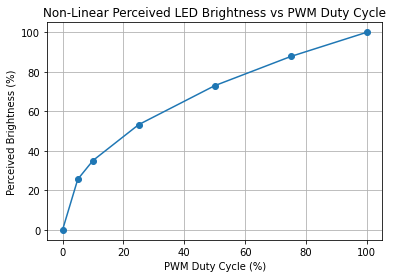

In [57]:
import matplotlib.pyplot as plt

# Plot duty_cycle to show non-linearity
plt.figure()
plt.plot(duty_cycles, brightness, marker='o')
plt.xlabel("PWM Duty Cycle (%)")
plt.ylabel("Perceived Brightness (%)")
plt.title("Non-Linear Perceived LED Brightness vs PWM Duty Cycle")
plt.grid(True)
plt.show()
